# Space Craft Detection Model Using YOLO
#### Author: Cody Ourique

In [10]:
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
import shutil
import random
import os

PROJ_DIRECTORY = Path.cwd().parent
DATA_DIRECTORY = PROJ_DIRECTORY / "data"
DEV_DIRECTORY = PROJ_DIRECTORY / "data_dev"
IMAGES_DIRECTORY_BALANCED = DEV_DIRECTORY / "balanced_images"
IMAGES_DIRECTORY_SOURCE = DEV_DIRECTORY / "images"
IMAGES_DIRECTORY_TRAIN = PROJ_DIRECTORY/ "notebooks/datasets/images/train"
IMAGES_DIRECTORY_VAL = PROJ_DIRECTORY/ "notebooks/datasets/images/val"
IMAGES_DIRECTORY_TEST = PROJ_DIRECTORY/ "notebooks/datasets/images/test"

/Users/admin/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Exploritory Data Analysis

In [11]:
train_meta = pd.read_csv(DEV_DIRECTORY / "metadata.csv", index_col="image_id")
train_labels = pd.read_csv(DEV_DIRECTORY / "labels.csv", index_col="image_id")

In [12]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def get_bbox(image_id, labels):
    """Get bbox coordinates as list from dataframe for given image id."""
    return labels.loc[image_id].loc[["xmin", "ymin", "xmax", "ymax"]].values.tolist()

def display_image(image_id, images_dir=IMAGES_DIRECTORY_BALANCED, show_bbox=False, labels=train_labels):
    """Display image given image ID. Annotate with bounding box if `show_bbox` is True."""
    img = cv2.imread(str(images_dir / f"{image_id}.png"))
    fig, ax = plt.subplots()
    # cv2 reads images as BGR order; we should flip them to RGB for matplotlib
    # ref: https://stackoverflow.com/questions/54959387/rgb-image-display-in-matplotlib-plt-imshow-returns-a-blue-image
    ax.imshow(np.flip(img, axis=-1))

    if show_bbox:
        xmin, ymin, xmax, ymax = get_bbox(image_id, labels)
        patch = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='white', linewidth=1)
        ax.add_patch(patch)

Image size: (1280, 1024)


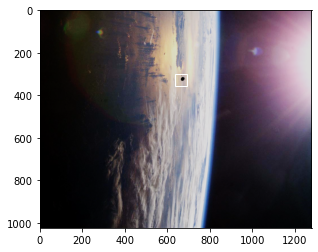

In [13]:
display_image("0a0ba7d4c31cd8c12e66f3e792a9599f", show_bbox=True)


image_path = IMAGES_DIRECTORY_BALANCED / "0a0ba7d4c31cd8c12e66f3e792a9599f.png"
image = Image.open(image_path)

# Get the size of the image
image_size = image.size

# Print the size of the image
print("Image size:", image_size)

In [14]:
# Check how many unique spacecraft ids exist so that we may create a proper mapping later
spacecraft_ids = sorted(train_meta['spacecraft_id'].unique())
print(f'Unique spacecraft ids: {spacecraft_ids}')

# Checking the number of rows in the dataset and their associated spacecraft id
print(f'Number of rows: {len(train_meta)}')
spacecraft_ids_count = train_meta['spacecraft_id'].value_counts()
print(spacecraft_ids_count)

Unique spacecraft ids: [2, 3, 5, 6, 11, 13, 14, 18, 19, 20, 22, 24, 25, 28, 30]
Number of rows: 25801
spacecraft_id
28    2103
24    2096
25    2054
30    2012
18    1845
20    1833
19    1775
14    1725
6     1659
22    1640
11    1580
5     1515
3     1479
2     1287
13    1198
Name: count, dtype: int64


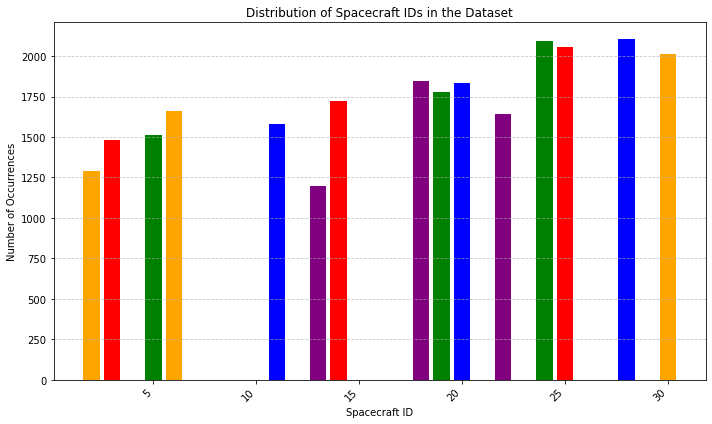

In [41]:
# Provide graph illustrating unbalanced data

def plot_spacecraft_ids(spacecraft_ids_count):
    """
    This function takes a unique array of spacecraft ids and their associated counts and plots 
    a bar chart with the number of occurrences for each class of spacecraft.
    """
    spacecraft_ids = spacecraft_ids_count.index.to_list()
    counts = spacecraft_ids_count.to_numpy()    
    # Create a bar chart
    plt.figure(figsize=(10, 6))  
    plt.bar(spacecraft_ids, counts, color=['blue', 'green', 'red', 'orange', 'purple'])
    plt.xlabel('Spacecraft ID')
    plt.ylabel('Number of Occurrences')
    plt.title('Distribution of Spacecraft IDs in the Dataset')
    plt.xticks(rotation=45, ha='right')  


    plt.grid(axis='y', linestyle='--', alpha=0.7) 
    plt.tight_layout()  

    plt.show()

plot_spacecraft_ids(spacecraft_ids_count)

In [22]:
# Check for missing values
missing_values = train_meta.isna().sum()
print(f'Missing Values in Train Metadata:\n{missing_values}\n')

missing_values = train_labels.isna().sum()
print(f'Missing Values in Train Labels:\n{missing_values}\n')


Missing Values in Train Metadata:
spacecraft_id    0
background_id    0
dtype: int64

Missing Values in Train Labels:
xmin    0
ymin    0
xmax    0
ymax    0
dtype: int64



In [23]:
# Check for duplicate rows
# Eventhough there is duplicate information, all image ids remain unique
duplicate_rows = train_meta[train_meta.duplicated()]
print(f'Duplicate Rows Train Metadata:\n{duplicate_rows}\n')

duplicate_rows = train_labels[train_labels.duplicated()]
print(f'Duplicate Rows Train Metadata:\n{duplicate_rows}\n')

Duplicate Rows Train Metadata:
                                  spacecraft_id  background_id
image_id                                                      
002b44411932ed2befd9a8e90bfcc6f2             30            194
00523e058b79316b17f22f6ce509babe             28             13
00644572c7e8a05b014fa2d19bb4948d             28             12
006494f06995cfbd26bec2611023b464             28             15
009ca49e6f61962a04c288f8711e170f             20            112
...                                         ...            ...
ffefb0578bfd52f492596e94b6e93568             11             10
fff2c166a7807d6c2a738a3e0cd2accf             11             17
fff56ebfd6d6ada3ce965eeaa81c871a             28            247
fff6843668de441c20270bbd93479a1a             22            273
fffb1f4bbf1d3d2bdb947f47e693ab0d             24            125

[22792 rows x 2 columns]

Duplicate Rows Train Metadata:
                                  xmin  ymin  xmax  ymax
image_id                           

### Data Preprocessing

In [24]:
# Now we need to merge the metadata and labels so that the spaceships in the labeled data have their spaceship ID

# Lets print out the length of the data frames to ensure they have the same quantity of observations
print(len(train_meta))
print(len(train_labels))

# Merge DataFrames on image_id using inner join
merged_df = pd.merge(train_meta, train_labels, on='image_id', how='inner')

# Check that merge was successful by checking for NaN values
nan_count_rows = merged_df.isna().sum()
print(nan_count_rows)
print(merged_df.index.size)

# Lets check the size of the merged dataframe and peak at its contents
print(len(merged_df))
merged_df.tail(10)

25801
25801
spacecraft_id    0
background_id    0
xmin             0
ymin             0
xmax             0
ymax             0
dtype: int64
25801
25801


,spacecraft_id,background_id,xmin,ymin,xmax,ymax
image_id,,,,,,
ffe63405a853e67940e4042b611b07a2,18,154,953,247,1077,346
ffe6c765314141402040dd1366b2f0c4,28,236,48,5,744,539
ffeb658bebeb21861c310f7365eb7cbe,11,150,283,0,1280,678
ffeb84fd019ad4678e69f97e016d0003,13,2,770,851,782,865
ffed50fcd56e8435ffedc1b66f98890e,25,7,209,42,252,303
ffefb0578bfd52f492596e94b6e93568,11,10,302,599,441,720
fff2c166a7807d6c2a738a3e0cd2accf,11,17,686,324,850,636
fff56ebfd6d6ada3ce965eeaa81c871a,28,247,325,170,633,525
fff6843668de441c20270bbd93479a1a,22,273,358,181,580,336


<class 'pandas.core.frame.DataFrame'>
spacecraft_id
28    350
24    350
25    350
30    350
18    350
20    350
19    350
14    350
6     350
22    350
11    350
5     350
3     350
2     350
13    350
Name: count, dtype: int64


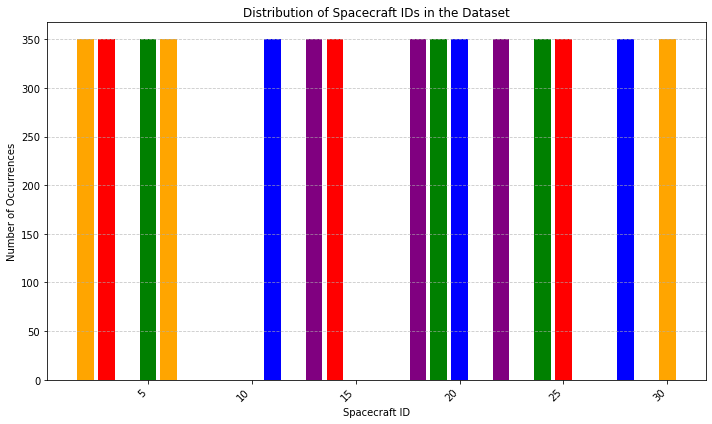

In [42]:

def random_sample_spacecraft(df_spacecraft, value):
    """
    This function takes a dataframe of spacecrafts and a spacecraft ID and returns a random
    sample of that spacecraft id.
    """
    sample = df_spacecraft.loc[df_spacecraft['spacecraft_id']==value].sample(n=350, random_state=42)
    return sample

def balance_spacecraft_classes(df_spacecraft):
    """
    This function takes a dataframe of spacecrafts and iterates through all the spacecraft
    IDs. It takes an even distribution of all the IDs to ensure the dataset returned is balanced. 
    """

    # Iterate through all the different types of spacecraft and take random samples
    sample_list = []
    for i in spacecraft_ids:
      sample_list.append(random_sample_spacecraft(df_spacecraft, i))

    # Check the type of the contents of the list and concatenate the dataframes
    print(type(sample_list[0]))
    df_balanced = pd.concat(sample_list)

    # Check the newly merged dataframe and ensure it has the correct attributes
    # print(f'Unique spacecraft_ids: {df_balanced["spacecraft_id"].unique()}')
    # print(f'Spacecraft_id value counts: \n{df_balanced["spacecraft_id"].value_counts()}')
    # print(f'Number of rows: {len(df_balanced)}')
    # print(df_balanced.head())

    return df_balanced

df_spacecraft = balance_spacecraft_classes(merged_df)
print(df_spacecraft["spacecraft_id"].value_counts())
# Check the distribution of the newly balanced dataframe
plot_spacecraft_ids(df_spacecraft["spacecraft_id"].value_counts())

In [50]:
def reorganize_spacecraft_files(df_spacecraft, source_folder, destination_folder):
    
    """
    This function uses the balanced dataframe to copy all associated images from their source folders 
    to a balanced folder. 
    """
    for index, row in tqdm(df_spacecraft.iterrows(), total=len(df_spacecraft)):
      # Get the image ID from the row
      image_id = row["image_id"]

      # Construct destination and check if image was already copied
      destination_image_path = os.path.join(destination_folder, f"{image_id}.png")
      # if os.path.exists(destination_image_path):
      #    continue
      
      # Construct the source path
      source_image_path = os.path.join(source_folder, f"{image_id}.png")  

      if os.path.exists(source_image_path):
        # Copy the image from source to destination
        shutil.copy(source_image_path, destination_image_path)

        # Sleep to allow the system to breathe 
        time.sleep(0.1)
      else:
        print(f"Image not found: {image_id}.png")

reorganize_spacecraft_files(df_spacecraft, IMAGES_DIRECTORY_SOURCE, IMAGES_DIRECTORY_BALANCED)


<class 'pandas.core.frame.DataFrame'>
Unique spacecraft_ids: [ 2  3  5  6 11 13 14 18 19 20 22 24 25 28 30]
Spacecraft_id value counts: 
spacecraft_id
2     350
3     350
5     350
6     350
11    350
13    350
14    350
18    350
19    350
20    350
22    350
24    350
25    350
28    350
30    350
Name: count, dtype: int64
Number of rows: 5250
                               image_id  spacecraft_id  background_id  xmin  \
25027  f8a928adfc32c8ba6b7012d1f29b0569              2            141   275   
6020   3cc37d75b77a516ade00a8b9b2a0c2a8              2             17    71   
18501  b8302392182b056f856776d91e42e1e4              2            111   206   
7679   4ced251f2e1f4843f2a598e3be3cf674              2            127   825   
23893  edd8b102982070a13c5656e9deeb6da3              2             15  1002   

       ymin  xmax  ymax  
25027   904   379   921  
6020    250   125   330  
18501   448   238   542  
7679    443  1238   732  
23893   134  1034   248  


  5%|▌         | 276/5250 [00:29<06:52, 12.05it/s]

Image not found: ddea26e7411fbe475f025626e5554fd1.png


 93%|█████████▎| 4863/5250 [17:53<00:57,  6.74it/s]  

Image not found: ddd6f3e86b66b52f6dcadb33e91cf195.png


100%|██████████| 5250/5250 [19:41<00:00,  4.44it/s]


In [52]:
def split_train_test_val(source_dir, train_dir, val_dir, test_dir,train_ratio=0.8, val_ratio=0.1):
    """
    This function moves image files that are in one balanced directory into the directories 
    needed for training which are image/test, image/train, image/val. 
    """
    
    # Check to see if the train, test and val directories exist and make them if the don't
    for directory in [train_dir, val_dir, test_dir]:
      if not os.path.exists(directory):
          os.makedirs(directory)

    # Get list of filenames in the source directory
    filenames = os.listdir(source_dir)
    random.shuffle(filenames)

    # Calculate the number of samples for each set train(80%), test(10%), val(10%)
    num_samples = len(filenames)
    num_train = int(num_samples * train_ratio)
    num_val = int(num_samples * val_ratio)

    # Assign filenames to each set
    train_filenames = filenames[:num_train]
    val_filenames = filenames[num_train:num_train+num_val]
    test_filenames = filenames[num_train+num_val:]

    # Copy files to respective directories
    for filename in train_filenames:
        shutil.move(os.path.join(source_dir, filename), os.path.join(train_dir, filename))
    for filename in val_filenames:
        shutil.move(os.path.join(source_dir, filename), os.path.join(val_dir, filename))
    for filename in test_filenames:
        shutil.move(os.path.join(source_dir, filename), os.path.join(test_dir, filename))

split_train_test_val(IMAGES_DIRECTORY_BALANCED, IMAGES_DIRECTORY_TRAIN, IMAGES_DIRECTORY_VAL, IMAGES_DIRECTORY_TEST, 0.8, 0.1)

In [43]:
def scale_bbox_to_yolo_format(df_row, image_path):
    """
    This function is used to scale the whole number x,y coordinates between 0 and 1 
    then calculate the x,y center and width and height of the bounding box.
    """
    # Try to open image and in case of failure return None 
    try:
        image = Image.open(image_path)
    except Image.UnidentifiedImageError:
        print(f"UnidentifiedImageError: Cannot identify image file {image_path}. Skipping...")
        return None, None, None, None
    
    width = image.size[0]
    height = image.size[1]
    # width = 1280
    # height = 1024

    # Calculate the center of the bounding boxes
    bbox_width = df_row["xmax"] - df_row["xmin"]
    bbox_height = df_row["ymax"] - df_row["ymin"]
    x_center = df_row["xmin"] + (bbox_width / 2.0)
    y_center = df_row["ymin"] + (bbox_height / 2.0)

    # Normalize coordinates
    x_center /= width
    y_center /= height

    bbox_width /= width
    bbox_height /= height

    return x_center, y_center, bbox_width, bbox_height

In [59]:
# Convert CSV to YOLO 

# File paths for data IO
labels_csv_path = "/Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/data_dev/labels.csv"
train_images_path = "/Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/images/train"  
val_images_path = "/Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/images/val"  
test_image_path = "/Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/images/test" 
train_output_path = "/Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/labels/train"  
val_output_path = "/Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/labels/val"
test_output_path = "/Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/labels/test"

# Function to convert a single CSV file to YOLOv8 format
def convert_csv_to_yolo(csv_file, images_path, output_path):
    """
    This function takes the labels CSV file and the path to the images and the path to where they will be stored.
    The purpose of this function is to convert each row in the CSV file into a corresponding txt file and store the
    file in the correct location. 
    """
    # Create a hashmap so that it will be more efficient when writing to the txt file
    df_labels = merged_df
    spacecraft_ids_map = {}

    for i in range(len(spacecraft_ids)):
        spacecraft_ids_map[spacecraft_ids[i]] = i

    # Verify that the values are correctly stored in the map
    print(spacecraft_ids_map)

    for index, row in df_labels.iterrows():
        # If path to image does not exist then skip to the next iteration
        file_path = os.path.join(images_path, row["image_id"] + ".png")
        if not os.path.exists(file_path):
            continue
        
        # Scale and calculate the necessary values for the txt file and continue to next iteration 
        # if there are missing values 
        x_center, y_center, bbox_width, bbox_height = scale_bbox_to_yolo_format(row, file_path)
        if (x_center == None):
            continue
        # print(f'x_center: {x_center}, y_center: {y_center}, bbox_width: {bbox_width}, bbox_height: {bbox_height}')     
        
        # Write values to txt file and in the correct location
        output_file = os.path.join(output_path, row["image_id"] + ".txt")
        with open(output_file, "w") as f:
            f.write(f"{spacecraft_ids_map.get(row['spacecraft_id'])} {x_center} {y_center} {bbox_width} {bbox_height}")
   
# Call this function for train, val, and test images paths 
convert_csv_to_yolo(labels_csv_path, train_images_path, train_output_path)
convert_csv_to_yolo(labels_csv_path, val_images_path, val_output_path)
convert_csv_to_yolo(labels_csv_path, test_image_path, test_output_path)

{2: 0, 3: 1, 5: 2, 6: 3, 11: 4, 13: 5, 14: 6, 18: 7, 19: 8, 20: 9, 22: 10, 24: 11, 25: 12, 28: 13, 30: 14}
{2: 0, 3: 1, 5: 2, 6: 3, 11: 4, 13: 5, 14: 6, 18: 7, 19: 8, 20: 9, 22: 10, 24: 11, 25: 12, 28: 13, 30: 14}
{2: 0, 3: 1, 5: 2, 6: 3, 11: 4, 13: 5, 14: 6, 18: 7, 19: 8, 20: 9, 22: 10, 24: 11, 25: 12, 28: 13, 30: 14}


### Model Training

In [11]:
from ultralytics import YOLO
from ultralytics.data.utils import check_det_dataset

# Sanity check to make sure that all classes are in the data.yaml file
data = check_det_dataset("data.yaml")
names = data["names"]
print(names)
print(len(names))

# Load a model
model = YOLO("yolov8n.yaml")  # build a new model from scratch
# model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use and train the model
results = model.train(data="data.yaml", epochs=1)  
# metrics = model.val()  # evaluate model performance on the validation set
# # results = model("https://ultralytics.com/images/bus.jpg")  # predict on an image
# path = model.export(format="onnx")  # export the model to ONNX format

{0: '2', 1: '3', 2: '5', 3: '6', 4: '11', 5: '13', 6: '14', 7: '18', 8: '19', 9: '20', 10: '22', 11: '24', 12: '25', 13: '28', 14: '30'}
15
Ultralytics YOLOv8.2.12 🚀 Python-3.8.5 torch-2.1.0 CPU (Intel Core(TM) i9-9980HK 2.40GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train52, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, emb

train: Scanning /Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/labels/train... 1579 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1579/1579 [00:11<00:00, 141.23it/s]

train: New cache created: /Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/labels/train.cache



val: Scanning /Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/labels/val... 1557 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1557/1557 [00:11<00:00, 131.04it/s]

val: New cache created: /Users/admin/Desktop/ISE_244/Final_Project/Final_Project_Transfer_Learning/Space-Craft-Detection-Model/notebooks/datasets/labels/val.cache


Plotting labels to runs/detect/train52/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train52
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      3.784      7.424      4.322         19        640: 100%|██████████| 99/99 [15:52<00:00,  9.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [05:31<00:00,  6.77s/it]


                   all       1557       1557    1.4e-05   0.000673   8.34e-06   8.34e-07

1 epochs completed in 0.359 hours.
Optimizer stripped from runs/detect/train52/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train52/weights/best.pt, 6.2MB

Validating runs/detect/train52/weights/best.pt...
Ultralytics YOLOv8.2.12 🚀 Python-3.8.5 torch-2.1.0 CPU (Intel Core(TM) i9-9980HK 2.40GHz)
YOLOv8n summary (fused): 168 layers, 3008573 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 49/49 [04:55<00:00,  6.02s/it]


                   all       1557       1557   1.16e-05    0.00202   7.54e-06   1.35e-06
                     2       1557         75          0          0          0          0
                     3       1557         87          0          0          0          0
                     5       1557         88          0          0          0          0
                     6       1557         88          0          0          0          0
                    11       1557        108          0          0          0          0
                    13       1557         62          0          0          0          0
                    14       1557        106          0          0          0          0
                    18       1557         99   0.000174     0.0303   0.000113   2.03e-05
                    19       1557        103          0          0          0          0
                    20       1557        106          0          0          0          0
                    2